# Notebook: HumanEval Evaluation (pass@10)

This notebook performs the **final evaluation phase** of the GRPO verifiable-reward coding project using the **HumanEval benchmark**, reporting **pass@10** results.

---

## Objective

Evaluate and compare the functional correctness of multiple models trained under different regimes:

- **Base model** (no fine-tuning)
- **SFT model** (supervised fine-tuning warm-up)
- **GRPO model** (verifiable-reward reinforcement learning)

Each model is evaluated in both:
- **Non-CoT mode** (direct code completion)
- **CoT mode** (reasoning + solution, schema-constrained)

The goal is to measure **pass@10 performance**, capturing each model’s ability to produce *at least one correct solution* within **10 stochastic generations**, under a strict execution harness.

---

## Evaluation Protocol

1. **Prompt Construction**
   - Non-CoT: model completes the function body directly.
   - CoT: model is instructed to emit reasoning followed by a `<SOLUTION>` block.

2. **Multi-Sample Generation**
   - For each HumanEval task, **10 independent samples** are generated (`n=10`).
   - Sampling uses a non-zero temperature to encourage solution diversity.
   - vLLM batch inference is used for speed and reproducibility.

3. **Output Sanitization**
   A custom `cleaner` function enforces:
   - Strict `<SOLUTION>` extraction (CoT only)
   - Markdown fence removal (```python … ```)
   - Redundant `def` removal
   - Docstring stripping
   - Context-aware indentation repair
   - Final global indentation to satisfy HumanEval’s completion semantics

4. **Execution-Based Scoring**
   - All generated completions are executed against the official HumanEval tests.
   - A problem is marked **correct** if *any* of the 10 samples passes all tests.

---

## Metrics

- **pass@10**: fraction of problems for which at least one of 10 generated samples is correct
- Results are reported per model and per generation mode (CoT / non-CoT)

The HumanEval harness automatically aggregates multiple samples per task; no manual grouping logic is required.

---

## Output Artifacts

- `*_non_cot_pass10.jsonl` — non-CoT completions (10 samples per task)
- `*_cot_pass10.jsonl` — CoT completions (10 samples per task)
- `df_results` — consolidated evaluation table with pass@10 scores

These artifacts provide a **distribution-level view** of model capability beyond single-sample accuracy.

---

## Interpretation Notes

- **pass@10 is a saturation-prone metric** on HumanEval, especially under CoT prompting.
- Improvements observed in **pass@1** may not translate to higher pass@10 once near-ceiling performance is reached.
- pass@10 primarily reflects *coverage*, while pass@1 reflects *policy sharpness*.

Both metrics are therefore complementary and should be interpreted together.

---

## Result Summary

- Cleaner bugs affecting CoT indentation and redundant function headers were resolved
- All final evaluations used correctly merged, full-precision model weights
- GRPO improves single-sample correctness (pass@1) while matching SFT at pass@10 due to benchmark saturation
- Non-CoT pass@10 shows modest but consistent gains under GRPO

These results confirm that GRPO reshapes the solution distribution without inflating benchmark scores artificially.

# Step 1: Mounting Google Drive and Importing Libraries


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/grpo-verified-reasoner
!ls

Mounted at /content/drive
/content/drive/MyDrive/grpo-verified-reasoner
data			      LICENSE	 outputs    unsloth_compiled_cache
grpo_trainer_lora_model       models	 README.md  _unsloth_sentencepiece_temp
huggingface_tokenizers_cache  notebooks  src	    wandb


In [ ]:
# Install UV (Faster pip)
!pip install --upgrade -qqq uv

In [ ]:
import os
import subprocess

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:False"

In [ ]:
# os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

In [ ]:
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install -q unsloth vllm human-eval tqdm
else:
    # Version matching for Colab GPUs
    try:
        import numpy, PIL
        get_numpy = f"numpy=={numpy.__version__}"
        get_pil   = f"pillow=={PIL.__version__}"
    except Exception:
        get_numpy, get_pil = "numpy", "pillow"

    try:
        is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except Exception:
        is_t4 = False

    # A100/H100: vllm 0.10.2, T4: vllm 0.9.2 + pinned triton
    get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")

    !uv pip install -qqq --upgrade \
        unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers tqdm human-eval
    !uv pip install -qqq {get_triton}

In [ ]:
import gc
import json
import re
import ast
import torch
import random
import textwrap
import numpy as np
from tqdm import tqdm
import pandas as pd

from unsloth import FastLanguageModel
from vllm import SamplingParams
from pathlib import Path

import matplotlib.pyplot as plt
from human_eval.data import read_problems, write_jsonl
from human_eval.evaluation import evaluate_functional_correctness

In [ ]:
SEED = 3407
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-8c736d8a-3461-77ee-9364-fae9f27b5f54)


# Step 2: Verifying GPU and Environment

In [ ]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch version: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


# Step 3: Setting Up the Main Variables

In [ ]:
# HumanEval evaluation settings
N_SAMPLES_PER_PROBLEM = 1          # pass@1 by default; raise to 5 or 10 if you later want pass@k
MAX_NEW_TOKENS_NON_COT = 512       # Non-CoT completions are usually short (function body)
MAX_NEW_TOKENS_COT = 2048           # CoT can be longer due to tags + full function

TEMP_NON_COT = 0.8                # low sampling noise; stable for benchmarking
TEMP_COT = 0.8                     # encourages exploration under schema (optional)

TOP_P = 0.95
MIN_P = 0.10

# Stop guards (prevent rambling without clipping typical solutions)
STOP_STRINGS = ["\nclass ", "\ndef ", "\nif __name__"]

In [ ]:

# Output paths (keep all artifacts under one folder)
EVAL_DIR = "data/evaluation"
os.makedirs(EVAL_DIR, exist_ok=True)

In [ ]:
BASE_MODEL_PATH = "unsloth/Qwen3-4B-Base"
SFT_MODEL_PATH  = "models/qwen3-4b-sft-merged-f32"
GRPO_MODEL_PATH = "models/qwen3-4b-grpo-merged-f32-final"

In [ ]:
COT_SYSTEM_PROMPT_HUMANEVAL = """You are a code-generation engine.
You must output your response in the following exact format:
<START_WORKING_OUT>
Concise reasoning steps required to solve the problem.
</END_WORKING_OUT>
<SOLUTION>
Valid Python code only.
</SOLUTION>
Do not output anything outside these tags."""

# Step 4: Loading HumanEval Problems

In [ ]:
# Load HumanEval problems: mapping task_id -> {"prompt", "test", "entry_point", ...}
problems = read_problems()  # dict: {task_id: {"prompt":..., "test":..., "entry_point":...}}
# Extract task IDs as a stable list (preserves dict order for reproducible runs)
task_ids = list(problems.keys())

print(f"Loaded HumanEval problems: {len(task_ids)}")
print("Example task_id:", task_ids[0])
print("\n--- Prompt Preview ---")
print(problems[task_ids[0]]["prompt"][:500])

Loaded HumanEval problems: 164
Example task_id: HumanEval/0

--- Prompt Preview ---
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """



# Step 5: Prompt Builders

In [ ]:
def build_non_cot_prompt(problem: dict) -> str:
    """
    Non-CoT: HumanEval-style continuation.
    We provide ONLY the HumanEval prompt.
    The harness will prepend this prompt again during execution.
    """
    return problem["prompt"]

In [ ]:
def build_cot_prompt(problem: dict, tokenizer) -> str:
    """
    CoT: Uses the same chat template distribution as SFT/GRPO training.
    Returns a fully formatted ChatML prompt string.
    """
    messages = [
        {"role": "system", "content": COT_SYSTEM_PROMPT_HUMANEVAL},
        {"role": "user", "content": problem["prompt"]},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

# Step 6: Output Post-processing Logic

In [ ]:
# Stop strings (for safety against rambling)
# These are conservative: they stop the model from starting a NEW definition / class / main block.
STOP_STRINGS = ["\nclass ", "\ndef ", "\nif __name__"]

SOLUTION_RE = re.compile(r"<SOLUTION>(.*?)</SOLUTION>", re.DOTALL | re.IGNORECASE)

In [ ]:
def extract_cot_solution(completion_only_text: str) -> str:
    """
    Extract code from <SOLUTION>...</SOLUTION>.
    Returns "" on failure (schema violation → harness will fail, which is correct behavior).
    """
    m = SOLUTION_RE.search(completion_only_text)
    if not m:
        return ""
    return m.group(1).strip()

In [ ]:
def truncate_on_stop_strings(text: str, stop_strings: list[str]) -> str:
    """
    Stops the completion if it begins a new unrelated block (def/class/main).
    This reduces harness crashes from rambling continuations.
    """
    cut = len(text)
    for s in stop_strings:
        idx = text.find(s)
        if idx != -1:
            cut = min(cut, idx)
    return text[:cut].rstrip()

In [ ]:
def cleaner(code: str, entry_point: str, use_cot: bool) -> str:
    """
    Clean model completions for HumanEval.
    - If use_cot: extract code inside <SOLUTION>...</SOLUTION>.
    - Strip markdown fences and the first docstring.
    - Remove typing imports.
    - If the entry_point is defined, drop its signature and dedent its body.
    - Otherwise dedent whole block relative to first real line.
    - Finally indent by 4 spaces for harness compatibility.
    """
    # A. CoT extraction: if requested, take only the content between <SOLUTION> tags.
    if use_cot:
        if "<SOLUTION>" in code:
            code = code.split("<SOLUTION>")[-1]
            if "</SOLUTION>" in code:
                code = code.split("</SOLUTION>")[0]
        else:
            # CoT requested but missing → indicate failure.
            return ""

    # B. Remove markdown fences and the first docstring to avoid indentation noise.
    code = code.replace("```python", "").replace("```", "")
    # Remove the first triple-quoted string (likely a module docstring or explanation).
    code = re.sub(r'(\s*("""|"\"\")[[\s\S]]*?\2)', '', code, count=1)

    lines = code.split('\n')
    filtered_lines = []

    # C. Pre-filter: drop 'from typing' imports as they are irrelevant for execution.
    for line in lines:
        if line.strip().startswith("from typing"):
            continue
        filtered_lines.append(line)

    lines = filtered_lines

    # D. Surgical dedent: if entry_point function is present, remove its header and
    #    dedent its body relative to the first non-blank body line.
    def_pattern = re.compile(rf"^\s*def\s+{re.escape(entry_point)}(\s*\(|\s*:)")

    header_index = -1
    for i, line in enumerate(lines):
        if def_pattern.match(line):
            header_index = i
            break

    final_lines = []

    if header_index != -1:
        # CASE 1: Found redundant function header (GRPO-style).
        # Keep helpers before the header unchanged.
        pre_header_lines = lines[:header_index]

        # Drop the header line; work with the body that follows.
        post_header_lines = lines[header_index+1:]

        # Determine body indentation from the first non-empty body line.
        body_indent = 0
        for line in post_header_lines:
            if line.strip():
                body_indent = len(line) - len(line.lstrip())
                break

        # Dedent each body line by body_indent (but never negative).
        normalized_body = []
        for line in post_header_lines:
            if not line.strip():
                normalized_body.append("")
                continue
            current = len(line) - len(line.lstrip())
            new_indent = max(0, current - body_indent)
            normalized_body.append(" " * new_indent + line.lstrip())

        final_lines = pre_header_lines + normalized_body

    else:
        # CASE 2: No explicit header found (SFT-style or nested definitions).
        # Dedent entire block relative to the first substantive line.
        global_indent = 0
        for line in lines:
            if line.strip() and not line.strip().startswith(("import ", "from ")):
                global_indent = len(line) - len(line.lstrip())
                break

        for line in lines:
            if not line.strip():
                final_lines.append("")
                continue
            current = len(line) - len(line.lstrip())
            new_indent = max(0, current - global_indent)
            final_lines.append(" " * new_indent + line.lstrip())

    # E. Final: join and uniformly indent by 4 spaces for the evaluation harness.
    result = "\n".join(final_lines)
    return textwrap.indent(result, '    ')


# Step 7: Defining Evaluation Loop

In [ ]:
def evaluate_model(
    model_path: str,
    problems: dict,
    task_ids: list[str],
    *,
    use_cot: bool,
    output_jsonl: str,
    max_new_tokens: int,
    temperature: float,
    top_p: float = 0.95,
    min_p: float = 0.10,
    load_in_4bit: bool = False, # Controls 4-bit quantization (Must be False for correct results)
    dtype = torch.float16,      # Specifies precision (Must be float16 or float32)
    gpu_memory_utilization: float = 0.8,
    n: int = 10,                # NEW PARAMETER: Number of samples per prompt
):
    # Log current model, mode, and n for clarity
    print(f"\n Loading: {model_path} | Mode: {'CoT' if use_cot else 'Non-CoT'} | n={n}")
    print(f" Precision: {dtype} | 4-Bit Quantization: {load_in_4bit}")

    # Clear GPU memory before loading a new model
    gc.collect()
    torch.cuda.empty_cache()

    # Load the language model with specified precision and vLLM for inference
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_path,
        max_seq_length=4096,
        load_in_4bit=load_in_4bit, # Use 4-bit quantization if specified
        dtype=dtype,               # Load model with the desired data type
        fast_inference=True,       # Enable vLLM for faster inference
        gpu_memory_utilization=gpu_memory_utilization,
    )
    FastLanguageModel.for_inference(model) # Prepare model for inference mode

    prompts = []
    print(f" Preparing {len(task_ids)} prompts...")
    # Generate prompts for each task based on CoT or Non-CoT mode
    for task_id in task_ids:
        problem = problems[task_id]
        if use_cot:
            prompt_text = build_cot_prompt(problem, tokenizer)
        else:
            prompt_text = build_non_cot_prompt(problem)
        prompts.append(prompt_text)

    # Define stop tokens based on generation mode (CoT or Non-CoT)
    if use_cot:
        stop_tokens = ["</SOLUTION>"]
    else:
        stop_tokens = ["\nclass", "\nif __name__", "\nprint", "\ndef "]

    # Configure sampling parameters for vLLM generation
    sampling_params = SamplingParams(
        temperature=temperature,
        top_p=top_p,
        min_p=min_p,
        max_tokens=max_new_tokens,
        stop=stop_tokens,
        n=n, # CRITICAL: Generate n samples per prompt
    )

    print(f" Running vLLM Batch Generation (n={n})...")
    # Perform batch generation using the loaded model and sampling parameters
    outputs = model.fast_generate(prompts, sampling_params=sampling_params)

    samples = []
    # Process each generated output
    for i, task_id in enumerate(task_ids):
        problem = problems[task_id]

        # vLLM returns a list of 'n' outputs for each prompt
        # We must iterate through all n completions for this specific prompt
        for sample_idx in range(n):
            completion_only = outputs[i].outputs[sample_idx].text

            # Clean and format the completion using the 'cleaner' function
            completion = cleaner(completion_only, problem["entry_point"], use_cot)

            # Store task_id, original prompt, and cleaned completion
            samples.append({
                "task_id": task_id,
                "prompt": problem["prompt"],
                "completion": completion
            })

    # Write all processed samples to a JSONL file
    write_jsonl(output_jsonl, samples)
    print(f" Saved {len(samples)} samples to: {output_jsonl}")

    # Clean up model and tokenizer from GPU memory
    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()

# Step 8: Generating JSONL Files for Evaluation

In [ ]:
GEN_DIR = Path(EVAL_DIR) / "generations_run_2_pass@10"
GEN_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# BASE MODEL (Non-CoT)
evaluate_model(
    model_path=BASE_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "base_non_cot_pass@10.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
    n = 10,
)


 Loading: unsloth/Qwen3-4B-Base | Mode: Non-CoT | n=10
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 16:47:03 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 16:47:03 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/Qwen3-4B-Base with actual GPU utilization = 79.54%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 128.
Unsl

`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 01-11 16:47:35 [__init__.py:2767] Casting torch.bfloat16 to torch.float16.
INFO 01-11 16:47:35 [__init__.py:1815] Using max model len 4096
INFO 01-11 16:47:37 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-11 16:47:37 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

INFO 01-11 16:47:42 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='unsloth/Qwen3-4B-Base', speculative_config=None, tokenizer='unsloth/Qwen3-4B-Base', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=0, served_model_name=unsloth/Qwen3-4B-Base, enable_prefix_caching=True, chunked_prefill_enabled=True, use_async_output_proc=True, pooler_config=No

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

INFO 01-11 16:48:03 [weight_utils.py:369] Time spent downloading weights for unsloth/Qwen3-4B-Base: 19.492317 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 01-11 16:48:08 [default_loader.py:268] Loading weights took 3.98 seconds
INFO 01-11 16:48:08 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-11 16:48:09 [gpu_model_runner.py:2392] Model loading took 7.8056 GiB and 24.560947 seconds
INFO 01-11 16:48:24 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/6bdcbe920b/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 16:48:24 [backends.py:550] Dynamo bytecode transform time: 13.64 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 510.48it/s, triton_poi_fused_view_6]

INFO 01-11 16:48:25 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 524.50it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 16:48:34 [backends.py:215] Compiling a graph for dynamic shape takes 9.56 s


INFO 01-11 16:48:38 [monitor.py:34] torch.compile takes 23.19 s in total
INFO 01-11 16:48:39 [gpu_worker.py:298] Available KV cache memory: 54.53 GiB
INFO 01-11 16:48:40 [kv_cache_utils.py:864] GPU KV cache size: 397,072 tokens
INFO 01-11 16:48:40 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 96.94x
INFO 01-11 16:48:40 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:06<00:00,  5.71it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]

INFO 01-11 16:48:50 [gpu_model_runner.py:3118] Graph capturing finished in 10 secs, took 0.65 GiB
INFO 01-11 16:48:50 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 10 secs.


INFO 01-11 16:48:52 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.7954304147054094, 63.09 GiB). Actual usage is 7.81 GiB for weight, 0.74 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.65 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=57691607244` to fit into requested memory, or `--kv-cache-memory=74548069376` to fully utilize gpu memory. Current kv cache memory in use is 58551439564 bytes.
INFO 01-11 16:48:52 [core.py:218] init engine (profile, create kv cache, warmup model) took 42.78 seconds
INFO 01-11 16:48:54 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 16:48:54 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'input_layernorm', 'norm', 'post_feedforward_layernorm', 'post_attention_layernorm', 'ffn_norm', 'layer_norm2', 'q_norm', 'k_norm', 'attention_norm', 'norm1', 'post_layernorm

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/Qwen3-4B-Base and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'cross_attn_input_layernorm', 'input_layernorm', 'norm', 'post_feedforward_layernorm', 'post_attention_layernorm', 'ffn_norm', 'layer_norm2', 'q_norm', 'k_norm', 'attention_norm', 'norm1', 'post_layernorm', 'pre_feedforward_layernorm', 'cross_attn_post_attention_layernorm', 'norm2']
 Preparing 164 prompts...
 Running vLLM Batch Generation (n=10)...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1640 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

/tmp/ipython-input-3552671664.py:21: FutureWarning: Possible nested set at position 16
  code = re.sub(r'(\s*("""|"\"\")[[\s\S]]*?\2)', '', code, count=1)


 Saved 1640 samples to: data/evaluation/generations_run_2_pass@10/base_non_cot_pass@10.jsonl


In [ ]:
# SFT MODEL (Non-CoT)
evaluate_model(
    model_path=SFT_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "sft_non_cot_pass@10.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
    n = 10,
)


 Loading: models/qwen3-4b-sft-merged-f32 | Mode: Non-CoT | n=10
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 16:43:34 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 16:43:34 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-sft-merged-f32 with actual GPU utilization = 15.89%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Seq

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 16:43:59 [default_loader.py:268] Loading weights took 9.76 seconds
INFO 01-11 16:44:00 [gpu_model_runner.py:2392] Model loading took 7.7976 GiB and 9.940193 seconds
INFO 01-11 16:44:14 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/343b7bb7ec/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 16:44:14 [backends.py:550] Dynamo bytecode transform time: 12.66 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 476.46it/s, triton_poi_fused_view_6]

INFO 01-11 16:44:15 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 449.69it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 16:44:24 [backends.py:215] Compiling a graph for dynamic shape takes 9.08 s


INFO 01-11 16:44:27 [monitor.py:34] torch.compile takes 21.74 s in total
INFO 01-11 16:44:29 [gpu_worker.py:298] Available KV cache memory: 4.44 GiB
INFO 01-11 16:44:30 [kv_cache_utils.py:864] GPU KV cache size: 32,320 tokens
INFO 01-11 16:44:30 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 7.89x
INFO 01-11 16:44:30 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-11 16:44:30 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 11/11 [00:01<00:00,  5.61it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]

INFO 01-11 16:44:33 [gpu_model_runner.py:3118] Graph capturing finished in 3 secs, took 0.05 GiB
INFO 01-11 16:44:33 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.
INFO 01-11 16:44:33 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.


INFO 01-11 16:44:35 [gpu_worker.py:391] Free memory on device (15.75/79.32 GiB) on startup. Desired GPU memory utilization is (0.15889204639455687, 12.6 GiB). Actual usage is 7.8 GiB for weight, 0.36 GiB for peak activation, 0.0 GiB for non-torch memory, and 0.05 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=4555665919` to fit into requested memory, or `--kv-cache-memory=7938765312` to fully utilize gpu memory. Current kv cache memory in use is 4767478271 bytes.
INFO 01-11 16:44:36 [core.py:218] init engine (profile, create kv cache, warmup model) took 35.27 seconds
INFO 01-11 16:44:36 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 16:44:36 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm', 'k_norm', 'norm2', 'layer_norm1', 'attention_norm', 'norm', 'post_attention_layernorm', 'post_layernorm', 'norm1', 'q_norm', 'layer_nor

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-sft-merged-f32 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm', 'k_norm', 'norm2', 'cross_attn_post_attention_layernorm', 'cross_attn_input_layernorm', 'layer_norm1', 'attention_norm', 'norm', 'post_attention_layernorm', 'post_layernorm', 'norm1', 'q_norm', 'layer_norm2', 'ffn_norm', 'input_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation (n=10)...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1640 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

 Saved 1640 samples to: data/evaluation/generations_run_2_pass@10/sft_non_cot_pass@10.jsonl


In [ ]:
# SFT MODEL (CoT)
evaluate_model(
    model_path=SFT_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=True,
    output_jsonl=str(GEN_DIR / "sft_cot_pass@10.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_COT,
    temperature=TEMP_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
    n = 10,
)


 Loading: models/qwen3-4b-sft-merged-f32 | Mode: CoT | n=10
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 16:36:58 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 16:36:58 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-sft-merged-f32 with actual GPU utilization = 79.54%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequenc

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-11 16:37:27 [__init__.py:2764] Downcasting torch.float32 to torch.float16.
INFO 01-11 16:37:27 [__init__.py:1815] Using max model len 4096
INFO 01-11 16:37:28 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-11 16:37:28 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
INFO 01-11 16:37:32 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='models/qwen3-4b-sft-merged-f32', speculative_config=None, tokenizer='models/qwen3-4b-sft-merged-f32', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 16:40:30 [default_loader.py:268] Loading weights took 175.81 seconds
INFO 01-11 16:40:30 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-11 16:40:31 [gpu_model_runner.py:2392] Model loading took 7.8056 GiB and 176.670305 seconds
INFO 01-11 16:40:45 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/0ac4129559/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 16:40:45 [backends.py:550] Dynamo bytecode transform time: 13.51 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 480.92it/s, triton_poi_fused_view_6]

INFO 01-11 16:40:47 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 545.44it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 16:40:56 [backends.py:215] Compiling a graph for dynamic shape takes 9.44 s


INFO 01-11 16:40:59 [monitor.py:34] torch.compile takes 22.94 s in total
INFO 01-11 16:41:01 [gpu_worker.py:298] Available KV cache memory: 54.53 GiB
INFO 01-11 16:41:02 [kv_cache_utils.py:864] GPU KV cache size: 397,072 tokens
INFO 01-11 16:41:02 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 96.94x
INFO 01-11 16:41:02 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:06<00:00,  5.80it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]

INFO 01-11 16:41:11 [gpu_model_runner.py:3118] Graph capturing finished in 9 secs, took 0.65 GiB
INFO 01-11 16:41:11 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 9 secs.


INFO 01-11 16:41:13 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.7954304147054094, 63.09 GiB). Actual usage is 7.81 GiB for weight, 0.74 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.65 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=57691607244` to fit into requested memory, or `--kv-cache-memory=74548069376` to fully utilize gpu memory. Current kv cache memory in use is 58551439564 bytes.
INFO 01-11 16:41:13 [core.py:218] init engine (profile, create kv cache, warmup model) took 42.02 seconds
INFO 01-11 16:41:14 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 16:41:14 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm', 'k_norm', 'norm2', 'layer_norm1', 'attention_norm', 'norm', 'post_attention_layernorm', 'post_layernorm', 'norm1', 'q_norm', 'laye

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-sft-merged-f32 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm', 'k_norm', 'norm2', 'cross_attn_post_attention_layernorm', 'cross_attn_input_layernorm', 'layer_norm1', 'attention_norm', 'norm', 'post_attention_layernorm', 'post_layernorm', 'norm1', 'q_norm', 'layer_norm2', 'ffn_norm', 'input_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation (n=10)...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1640 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

/tmp/ipython-input-3552671664.py:21: FutureWarning: Possible nested set at position 16
  code = re.sub(r'(\s*("""|"\"\")[[\s\S]]*?\2)', '', code, count=1)


 Saved 1640 samples to: data/evaluation/generations_run_2_pass@10/sft_cot_pass@10.jsonl


In [ ]:
# GRPO MODEL (Non-CoT)
evaluate_model(
    model_path=GRPO_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "grpo_non_cot_pass@10.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
    n = 10,
)


 Loading: models/qwen3-4b-grpo-merged-f32-final | Mode: Non-CoT | n=10
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 16:32:13 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 16:32:13 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-grpo-merged-f32-final with actual GPU utilization = 15.89%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens =

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 16:32:39 [default_loader.py:268] Loading weights took 10.13 seconds
INFO 01-11 16:32:41 [gpu_model_runner.py:2392] Model loading took 7.7976 GiB and 10.302335 seconds
INFO 01-11 16:32:55 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/759d6af8cf/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 16:32:55 [backends.py:550] Dynamo bytecode transform time: 12.65 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 314.94it/s, triton_poi_fused_view_6]

INFO 01-11 16:32:58 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 374.53it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-11 16:33:46 [backends.py:215] Compiling a graph for dynamic shape takes 50.06 s


INFO 01-11 16:34:00 [monitor.py:34] torch.compile takes 62.71 s in total
INFO 01-11 16:34:03 [gpu_worker.py:298] Available KV cache memory: 4.43 GiB
INFO 01-11 16:34:04 [kv_cache_utils.py:864] GPU KV cache size: 32,208 tokens
INFO 01-11 16:34:04 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 7.86x
INFO 01-11 16:34:04 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-11 16:34:04 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]

INFO 01-11 16:34:07 [gpu_model_runner.py:3118] Graph capturing finished in 3 secs, took 0.05 GiB
INFO 01-11 16:34:07 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.
INFO 01-11 16:34:07 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 3 secs.
INFO 01-11 16:34:10 [gpu_worker.py:391] Free memory on device (15.75/79.32 GiB) on startup. Desired GPU memory utilization is (0.15885264811099853, 12.6 GiB). Actual usage is 7.8 GiB for weight, 0.37 GiB for peak activation, 0.01 GiB for non-torch memory, and 0.05 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=4539727564` to fit into requested memory, or `--kv-cache-memory=7921988096` to fully utilize gpu memory. Current kv cache memory in use is 4751539916 bytes.


INFO 01-11 16:34:10 [core.py:218] init engine (profile, create kv cache, warmup model) took 88.78 seconds
INFO 01-11 16:34:11 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 16:34:11 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_attention_layernorm', 'post_feedforward_layernorm', 'input_layernorm', 'norm1', 'norm', 'q_norm', 'norm2', 'layer_norm2', 'layer_norm1', 'k_norm', 'ffn_norm', 'post_layernorm', 'attention_norm']


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-grpo-merged-f32-final and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['cross_attn_input_layernorm', 'cross_attn_post_attention_layernorm', 'pre_feedforward_layernorm', 'post_attention_layernorm', 'post_feedforward_layernorm', 'input_layernorm', 'norm1', 'norm', 'q_norm', 'norm2', 'layer_norm2', 'layer_norm1', 'k_norm', 'ffn_norm', 'post_layernorm', 'attention_norm']
 Preparing 164 prompts...
 Running vLLM Batch Generation (n=10)...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1640 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

 Saved 1640 samples to: data/evaluation/generations_run_2_pass@10/grpo_non_cot_pass@10.jsonl


In [ ]:
# GRPO MODEL (CoT)
evaluate_model(
    model_path=GRPO_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=True,
    output_jsonl=str(GEN_DIR / "grpo_cot_pass@10.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_COT, # Increased for safety, vLLM handles the speed
    temperature=TEMP_COT,
    load_in_4bit=False,    # Do not compress
    dtype=torch.float16,   # Do not round off
    n = 10,
)


 Loading: models/qwen3-4b-grpo-merged-f32-final | Mode: CoT | n=10
 Precision: torch.float16 | 4-Bit Quantization: False
INFO 01-11 16:21:47 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-11 16:21:47 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading models/qwen3-4b-grpo-merged-f32-final with actual GPU utilization = 79.54%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 409

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-11 16:22:16 [__init__.py:2764] Downcasting torch.float32 to torch.float16.
INFO 01-11 16:22:16 [__init__.py:1815] Using max model len 4096
INFO 01-11 16:22:18 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-11 16:22:18 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
INFO 01-11 16:22:22 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='models/qwen3-4b-grpo-merged-f32-final', speculative_config=None, tokenizer='models/qwen3-4b-grpo-merged-f32-final', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=c

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 01-11 16:25:22 [default_loader.py:268] Loading weights took 178.62 seconds
INFO 01-11 16:25:25 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-11 16:25:26 [gpu_model_runner.py:2392] Model loading took 7.8056 GiB and 181.620079 seconds
INFO 01-11 16:25:40 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/902f1ba83e/rank_0_0/backbone for vLLM's torch.compile
INFO 01-11 16:25:40 [backends.py:550] Dynamo bytecode transform time: 13.47 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 10.39it/s, triton_poi_fused_view_6]

INFO 01-11 16:25:46 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 26.16it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]


INFO 01-11 16:26:32 [backends.py:215] Compiling a graph for dynamic shape takes 50.84 s
INFO 01-11 16:26:53 [monitor.py:34] torch.compile takes 64.31 s in total
INFO 01-11 16:26:56 [gpu_worker.py:298] Available KV cache memory: 54.53 GiB
INFO 01-11 16:26:57 [kv_cache_utils.py:864] GPU KV cache size: 397,040 tokens
INFO 01-11 16:26:57 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 96.93x
INFO 01-11 16:26:57 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:14<00:00,  2.40it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]

INFO 01-11 16:27:14 [gpu_model_runner.py:3118] Graph capturing finished in 18 secs, took 0.65 GiB
INFO 01-11 16:27:14 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 18 secs.


INFO 01-11 16:27:16 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.7954304147054094, 63.09 GiB). Actual usage is 7.81 GiB for weight, 0.74 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.65 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=57689510092` to fit into requested memory, or `--kv-cache-memory=74545972224` to fully utilize gpu memory. Current kv cache memory in use is 58547245260 bytes.
INFO 01-11 16:27:16 [core.py:218] init engine (profile, create kv cache, warmup model) took 110.57 seconds
INFO 01-11 16:27:17 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-11 16:27:17 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_attention_layernorm', 'post_feedforward_layernorm', 'input_layernorm', 'norm1', 'norm', 'q_norm', 'norm2', 'layer_norm2', 'layer_norm1', 'k_norm', 'ffn_n

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at models/qwen3-4b-grpo-merged-f32-final and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['cross_attn_input_layernorm', 'cross_attn_post_attention_layernorm', 'pre_feedforward_layernorm', 'post_attention_layernorm', 'post_feedforward_layernorm', 'input_layernorm', 'norm1', 'norm', 'q_norm', 'norm2', 'layer_norm2', 'layer_norm1', 'k_norm', 'ffn_norm', 'post_layernorm', 'attention_norm']
 Preparing 164 prompts...
 Running vLLM Batch Generation (n=10)...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1640 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

/tmp/ipython-input-3552671664.py:21: FutureWarning: Possible nested set at position 16
  code = re.sub(r'(\s*("""|"\"\")[[\s\S]]*?\2)', '', code, count=1)


 Saved 1640 samples to: data/evaluation/generations_run_2_pass@10/grpo_cot_pass@10.jsonl


# Step 9: Calculating Pass@10

In [ ]:
def run_humaneval(
    samples_file: str,
    k: int = 1,
    timeout: float = 3.0,
):
    """
    Runs HumanEval pass@k on a JSONL file of completions.
    """
    # samples_file: path to JSONL produced by write_jsonl; each record must include
    #               "task_id" and "completion". Multiple completions per task allowed.
    # k: integer pass@k to compute (function wraps evaluate_functional_correctness which
    #    expects a list of ks).
    # timeout: per-test execution timeout (seconds).
    results = evaluate_functional_correctness(
        sample_file=samples_file,
        k=[k],
        timeout=timeout,
    )
    # returns a dict with keys like "pass@k" and detailed per-task status
    return results

In [ ]:
RESULTS = []
EVAL_RUNS = [
    ("Base", "Non-CoT", GEN_DIR / "base_non_cot_pass@10.jsonl"),
    ("SFT",  "Non-CoT", GEN_DIR / "sft_non_cot_pass@10.jsonl"),
    ("GRPO", "Non-CoT", GEN_DIR / "grpo_non_cot_pass@10.jsonl"),
    ("SFT",  "CoT",     GEN_DIR / "sft_cot_pass@10.jsonl"),
    ("GRPO", "CoT",     GEN_DIR / "grpo_cot_pass@10.jsonl"),
]

In [ ]:
for model_name, mode, path in EVAL_RUNS:
    print(f"\nEvaluating: {model_name} | {mode} | pass@10")
    res = run_humaneval(str(path), k=10)
    RESULTS.append({
        "Model": model_name,
        "Mode": mode,
        "pass@10": res["pass@10"],
    })
df_results = pd.DataFrame(RESULTS)
df_results


Evaluating: Base | Non-CoT | pass@10
Reading samples...


1640it [00:01, 1212.03it/s]


Running test suites...


100%|██████████| 1640/1640 [01:26<00:00, 19.01it/s]


Writing results to data/evaluation/generations_run_2_pass@10/base_non_cot_pass@10.jsonl_results.jsonl...


100%|██████████| 1640/1640 [00:00<00:00, 36089.31it/s]



Evaluating: SFT | Non-CoT | pass@10
Reading samples...


1640it [00:00, 2563.48it/s]


Running test suites...


100%|██████████| 1640/1640 [01:26<00:00, 18.88it/s]


Writing results to data/evaluation/generations_run_2_pass@10/sft_non_cot_pass@10.jsonl_results.jsonl...


100%|██████████| 1640/1640 [00:00<00:00, 27567.90it/s]



Evaluating: GRPO | Non-CoT | pass@10
Reading samples...


1640it [00:00, 2433.75it/s]


Running test suites...


100%|██████████| 1640/1640 [01:24<00:00, 19.45it/s]


Writing results to data/evaluation/generations_run_2_pass@10/grpo_non_cot_pass@10.jsonl_results.jsonl...


100%|██████████| 1640/1640 [00:00<00:00, 31743.50it/s]



Evaluating: SFT | CoT | pass@10
Reading samples...


1640it [00:00, 2352.85it/s]


Running test suites...


100%|██████████| 1640/1640 [01:30<00:00, 18.13it/s]


Writing results to data/evaluation/generations_run_2_pass@10/sft_cot_pass@10.jsonl_results.jsonl...


100%|██████████| 1640/1640 [00:00<00:00, 30217.53it/s]



Evaluating: GRPO | CoT | pass@10
Reading samples...


1640it [00:00, 2290.54it/s]


Running test suites...


100%|██████████| 1640/1640 [01:24<00:00, 19.44it/s]


Writing results to data/evaluation/generations_run_2_pass@10/grpo_cot_pass@10.jsonl_results.jsonl...


100%|██████████| 1640/1640 [00:00<00:00, 26530.97it/s]


,Model,Mode,pass@10
0,Base,Non-CoT,0.859756
1,SFT,Non-CoT,0.890244
2,GRPO,Non-CoT,0.908537
3,SFT,CoT,0.945122
4,GRPO,CoT,0.945122


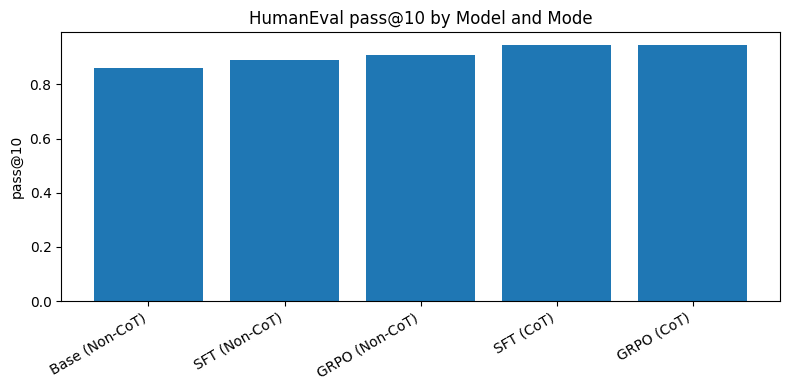

In [ ]:
df_results = df_results.copy()
df_results["Label_ml"] = df_results["Model"] + " (" + df_results["Mode"] + ")"

plt.figure(figsize=(8, 4))
plt.bar(df_results["Label_ml"], df_results["pass@10"])
plt.ylabel("pass@10")
plt.title("HumanEval pass@10 by Model and Mode")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Step 10: Fixing Metadata

In [ ]:
import nbformat
import os

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

In [ ]:
# List the notebook directory to confirm the file exists
os.listdir("/content/drive/MyDrive/grpo-verified-reasoner/notebooks")

In [ ]:
notebook_path = "/content/drive/MyDrive/grpo-verified-reasoner/notebooks/04_evaluation.ipynb"

with open(notebook_path, "r") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

with open(notebook_path, "w") as f:
    nbformat.write(nb, f)

print("Notebook fixed and saved successfully!")